In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

In [3]:
(trainX, trainy), (testX, testy) = mnist.load_data()

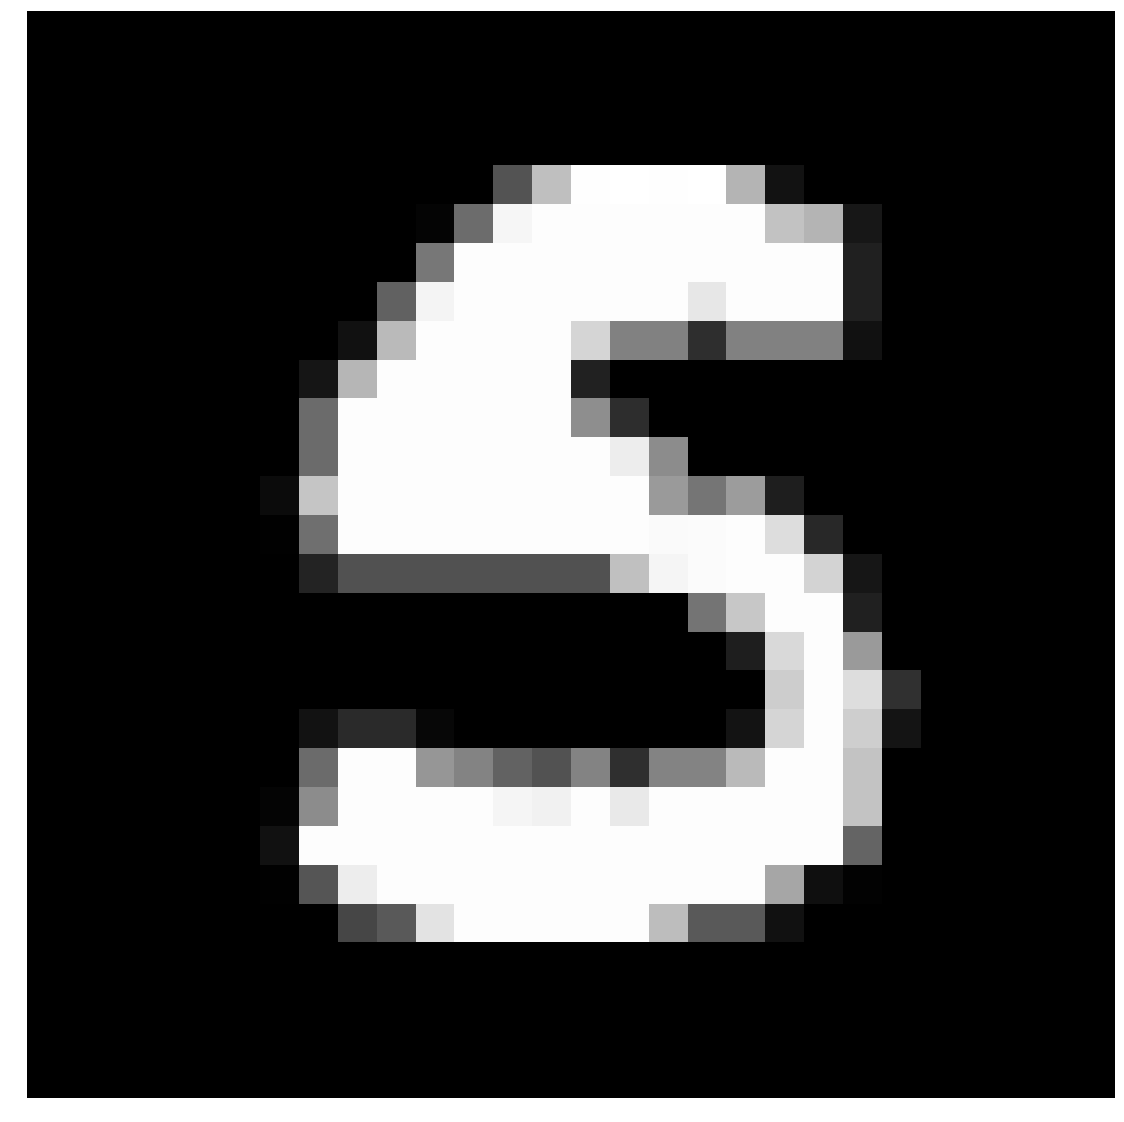

In [57]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [64]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.asarray([0.0]*(X.shape[0]+b+d)*(X.shape[1]+a+c)*X.shape[2]).reshape(X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2])
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    s=str(X.dtype)
    
    a=(re.search('float', s)==None)
    b=(re.search('int', s)==None)
    if (a==False):
        X=X.astype('float64')
    else:
        X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            #print('FFF', ff)
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    f1=pd.Series([True]*Y.shape[0])
    f2=pd.Series([True]*Y.shape[1])
    Exit=np.asarray(Y*0)
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.asarray(Y*0).astype('int64')
    Truth2=np.asarray(Y*0).astype('int64')
    Pure=np.asarray(Y*0)
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[(f1.index%mat[0])==i][:,(f2.index%mat[1])==j]
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    f1=pd.Series([1]*Y.shape[0])
    f2=pd.Series([1]*Y.shape[1])
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(f1[(f1.index%mat[0])==i].index),np.asarray(f2[(f2.index%mat[1])==j].index))]=X
    Y=Y*dim
    return Y

def dense_forw(W, L):
    return W*L

def dense_back(W, X, Der, cn):
    s1=cn*(Der*X)
    s2=cn*(W.T*x)
    return (s1, s2)

def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    for i in range(pred.shape[0]):
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.0000001):
                pred[i,0]=0.0000001
            elif(pred[i,0]>0.999999):
                pred[i,0]=0.999999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
    return (der, summ)

ccn=0.005
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))

loopz=30000

sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)

    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    dk1=w2.T*dk2

    #Back - 1.FC
    dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    dk0=w1.T*dk1

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    mtb2=[0]*10
    mtb3=[0]*10
    mtb4=[0]*10
    mtb5=[0]*10
    mtb6=[0]*10
    mtb7=[0]*10
    mtb8=[0]*10
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""

    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    w2-=weight_delta2*ccn
    matt-=Dr*ccn
    matt2-=Dr2*ccn

t2=time.time()
print(t2-t1)
print(s4)

7.259721275919718
9.896765372282848
7.900132720932516
8.033000343379888
9.399518177060576
9.208823112122849
9.026182789325722
6.54652414960903
7.057297056378948
6.89866396545388
6.46936888115824
6.011568057061203
8.108011920730588
9.525333424489855
6.009681055240492
7.866273399237396
8.513490358877386
5.630143038951975
8.329554935189568
7.925693659311094
7.6308278392955655
6.9597943026605815
7.4180959258601415
6.438996198462463
8.263530540845824
7.074295045239404
7.146711983521638
6.048126898458786
7.097846874948284
7.390347694451462
5.596961834517193
5.049792765202407
8.048707021647282
6.72106568100015
8.500698030580084
5.066388468817175
6.917885782557852
7.833810076909311
6.674889845951544
6.744323029438638
5.933686456790013
5.772169093060382
7.952198750433628
7.332842984897257
5.728312795831953
6.542277681826085
5.92118530467573
5.244033425577378
8.132981090341863
5.340788285502839
4.559809818917829
5.138287930178182
6.919177338135068
6.298793758110982
5.453089321782501
4.9029570415

2.118898785880826
3.614304138687543
3.229913822167464
3.656385833021153
2.4147075460607628
2.657033201665878
3.881072628571074
2.3010574912929838
3.149782134447381
3.467182007530232
3.0140312654115005
3.758163692320779
3.090059781592585
3.6920075636803005
3.98178104142384
3.6712392628940607
2.32696011179609
3.5393362027459836
2.818972378653435
3.115492342059036
2.3155444918241552
3.705314545131479
3.0679569675949487
2.8812324790193604
4.137142796710569
3.1662669452475396
3.2308281179065617
2.983601527030094
3.915139027577081
3.8549356672926907
3.1004036285518293
3.427725370470091
3.2698944380001818
3.54194107804378
2.3744727663303085
3.8076709680731664
3.1712980159992776
3.534774238234346
3.285222463162328
3.2579191976578588
2.541160409191545
2.951831289489454
2.59854942553747
2.5091473329914837
3.5389870354196162
3.1463189515048993
3.372498413154225
3.2932978874822205
3.4910425154159848
3.4754987545087297
3.321226913504217
3.8487827529136256
3.5619655258487217
3.2160113299130937
3.620

2.8952265885454773
3.572471779197092
3.14911873159965
3.149421994301697
3.5940809406892207
3.621673535520654
3.380684994992536
3.478320128368411
3.1118787801366183
2.8738340352246348
3.157659895201414
2.612024644615673
2.822724518389045
3.089961146355216
3.292218816263378
3.2928655084713
3.9110786706257734
2.863851978977523
3.6943308251696405
3.2297973035828877
3.02374650990493
3.355749108046549
3.7418953709498113
2.7372798997080805
2.7828548709357785
2.451661023569299
2.2745361322909594
3.7098039986996225
3.0858572447504167
2.8753118849562993
2.8394421888486137
2.8575482526325686
2.510979830041364
3.9788879750610135
3.276337733775103
3.5625754853266907
2.643237493959295
2.8927704540821395
2.6691014050335733
3.23918317945445
2.3832218220402352
2.4905181153639937
3.0636289925480162
3.1768827064778398
3.4403305522063765
3.731977570951416
3.0074757791995275
2.91633379763862
2.243465979705179
3.627847639766359
2.9637727413698918
3.391653741660941
2.8307813544179377
3.5346796630639705
2.921

2.804358434405845
3.1144704367200324
2.554450342932577
2.7327495635932793
3.1175253286184224
3.85203081391894
2.651763014552929
3.442075815462509
2.531597435754846
3.1840096202519623
2.578330920633573
3.2954532371628256
3.729842104810554
2.9019376483900445
3.546009265963907
2.897661931413759
2.2680456237564535
2.690106178426512
2.7394494777675855
4.013631252107055
3.5405304545600282
2.866941624852148
3.730096611374512
2.6732677810762926
4.214711699773364
3.361961911573463
3.4856256096147984
3.035193352551153
2.1029520801275994
2.991150248024682
2.9224203204158843
2.7658070183470387
2.1716054006158476
2.4673462730043916
2.942157403250386
2.9123042292255836
2.684553538293632
3.687532675907267
2.6588729622147613
3.318282018102965
3.4120634702400783
3.3405455479485524
2.690934317513768
2.893677955061842
2.4404048382865478
2.869933756123649
2.472413217934219
3.1339303949655264
3.287480692788427
2.835284487617177
3.571592903266894
2.36559366150071
2.896385360733893
4.102632374605651
3.242563

2.773339899050557
2.7492050774882726
2.853867486538185
2.4765770932068083
2.5134693241504427
3.563689907146471
2.481373323724911
1.843454824289623
3.3053594043861496
2.2237189313123875
3.026604437643376
3.2596855282817545
2.825192795029554
2.9369142177006218
2.4344011109113834
3.7717511047967074
3.758894717196608
2.7850093718163356
2.840333937229956
3.106171703334299
3.9635052636062738
2.5816278225351104
2.6323662506989325
2.3327420157450645
3.801706512147163
3.387762653323547
3.6514892000506616
1.8614852549588603
2.67104113045468
3.052684732336463
3.5256690537814688
2.198282007108867
2.6544733916817114
3.2238615282180185
2.9053343493606687
2.3622465897859297
2.2514904961299167
3.666415067309165
2.460638453123921
2.623783335454408
2.582698281672513
2.7918515626470426
2.2310508540357348
3.0065398800957173
4.0721044380272815
2.2151936960943726
2.8148208209782823
2.4550979947013256
2.4091348736038953
3.2778426422541904
2.3031918220094965
1.8911070432101538
3.4529002791387278
2.37173255234

2.117935888223238
3.3759841016358636
1.8571780212027
2.386756671777415
1.5481179393632338
2.6630202565734633
1.99970668446996
3.0362751654684956
2.974830122055651
2.6210689965029
2.731760460246924
3.2647819285501174
2.0639977638323703
2.1037784897718868
3.127791810167488
2.6928697429112667
2.494870807235806
2.5609209356451603
2.4848152686015217
2.9338711404727675
2.724251256170468
2.091404930972924
2.690854798174086
2.0248086767909568
3.119232221402888
3.571384895773958
3.0311221426913653
3.6135607564096386
2.8393455760604405
2.5094789949378398
2.2781370253058593
2.540450024390231
1.8158863442458557
2.351289877212654
2.272935632852711
3.7770932548976233
2.600427138481469
2.0467361641675343
2.9996055940869244
2.567216356975199
3.0597114359254154
2.260342079041914
2.5842311593133647
3.534100799840125
2.3592587267218836
3.409155175953386
2.5668476719574826
3.0055076083818304
1.961335307183913
3.2478964402279202
3.170318427807628
3.4122364345008984
3.2051791181371887
3.042335126406252
2.84

2.941224356003155
3.3061563385847332
2.7578467766113084
2.5911066207891773
3.8638481036624164
2.309967775898299
2.846871626447969
3.0780302424541444
3.6367066119702596
2.9703481154355584
2.9026997329889666
2.5638571513738957
2.6482645007573544
2.550497632286907
3.046973210936271
2.0385147164676205
3.308055995286396
2.344100455854682
1.9590055457531181
2.332995373992015
2.116904372565019
2.214213937384969
3.1201420563227646
2.3391590537841425
1.4796291623607543
2.9489412824221195
3.6149679266815307
1.8070836718436114
2.605461946787323
2.1984251474322445
2.32797261059618
2.522245103426414
3.2696996612679112
2.039963057518596
3.023528837225806
2.826860230078394
2.0502929529931726
2.5858688215566414
2.6900674017423016
3.538434850480927
1.8179566051606797
2.5793066447601016
2.354746524100458
1.9632596902436181
2.3985096714256153
3.668768798352937
3.228695480531088
2.330497707931779
1.5642270635964128
1.9043737119197748
3.2841657518351224
1.624893418480767
3.394022847365761
2.946731145104867

1.6871600556050568
2.9568873916545
1.4880585774229667
2.9465584917017713
2.905757409491412
1.8871651018070348
2.465559106604537
3.020432272046674
2.9024540627567372
1.59386941284167
3.2888801659214235
2.052396968899738
2.4581480782771896
2.4242287655551022
2.8785904507495697
3.2888261663060727
2.373562490360907
2.3556690005961287
3.852032601108067
1.345276035980799
1.8651222967846774
1.3324394173414658
2.758220251258307
2.853843614917864
2.4061646162646735
3.167903492482769
3.318856308647541
1.7834349363118922
2.3279165766391747
3.762985130628197
3.2037447561527115
2.673151553621668
1.8453618329718366
2.5007501326853547
1.4494263119296322
4.58424974999059
2.5429895479119886
3.3167953162590984
1.2942582276904953
2.897249954866736
2.1824820268258427
2.611814946435203
2.598307844638944
3.4410471148271866
1.3975331308821077
3.5401292777056046
2.7818067925685543
2.845837488452781
3.2739918585817467
2.818510281320955
2.4407538515063463
2.287764757335934
3.4097100311395843
2.8657951176998857


2.646457474029375
3.2119906740367488
1.8059090299239893
1.3947413263268835
1.6556392412971663
1.685686277581045
3.8443741938224636
2.936069657271518
1.7940184813865712
2.2946726750015842
1.204560608776331
2.2765919811574573
2.6680199875398896
4.288791016673549
1.6893283931660952
3.849852049699944
2.2071030607899687
3.3408737334013328
3.002649170300533
1.8650435884051537
3.4246244658645404
3.064352264322848
2.333252397217504
3.3411277085841498
2.6741914306320127
2.5899759802155207
1.7172103662704172
2.510091496412533
2.246543752421292
2.5680920327136927
1.239243910973886
2.6236847684397606
2.676644891825072
1.9565635338424243
1.9775967529730214
1.374163816866913
1.5493579841813185
1.901074230718995
2.521162207132063
2.7164388087564064
2.1038788791631506
4.579925580920168
1.8791123502277711
3.032852872249703
2.5955204044323805
1.19181223754985
1.7780345889506564
1.182513553201315
1.306314171246979
2.491377068216081
2.500891955693701
2.00190859371677
1.9582966853283286
3.16717914982655
2.

3.6872569813382388
2.4091679110449182
3.600973438186161
2.8463372938597566
2.322972085690599
2.9358821569190052
1.1812983280686122
1.7697351734599833
1.3501978492972793
1.13786696079409
3.2261581772314685
2.8810708504583156
2.184296412347321
3.1438877333301147
2.068473302366871
2.014753412695949
2.0968291916123194
2.77403509287571
1.9747379264829845
1.5027246348427572
1.7994445937875156
1.6154287783236527
2.068104386787498
2.634439147290091
2.8767782990658874
1.7923590057070335
2.6012115429923726
3.4130995756812417
2.2665986245132093
2.5283247597037444
2.565791429897305
2.717579938827705
3.034734914108594
2.9811124063670533
2.318159394647316
2.2551287541385148
2.1542510299912694
1.766729146257552
3.4389863197378494
1.9825275723084572
2.113520725370909
1.5028692520587934
1.9368880396755896
2.7102772357606573
2.8999705032433827
2.031667037882014
2.6172252028455834
2.2709057211984933
3.272133429672522
1.8548984825563652
1.6635436915786297
2.7373402515249223
2.523655815995676
2.71680781142

3.664353027857241
2.528720280857977
2.7859612904482027
2.9400920520214395
3.2328024761057814
2.391907585386737
1.3340518724863644
2.024960697221726
2.1173417031030715
2.1784705978754944
2.04749133865314
2.4070004880606874
1.8677939775285939
3.8947097904284673
3.13584072929002
2.917861853756246
2.904018662611844
1.7830091912545123
1.914676817573361
1.4724180247945426
3.144267085841891
1.7473551296790306
3.3359655797393573
4.004380802802415
1.278579070405097
3.1565987007570304
1.3584900630536072
1.7765322656567006
1.9239906997897114
3.587857019651741
2.7316281530497086
2.150537125718988
1.6832995011875331
1.483085287081688
2.9464293968924364
2.9848971703720744
2.2536947289792044
2.131839501285849
1.2182161990155473
1.5484852373840576
1.46583430630055
1.087752014400007
2.8940540876653094
3.8972913149907575
2.450382402989736
2.3346563964859675
1.3714320040518722
2.3366237791748876
2.5508810306405465
4.245638093945881
2.1911535765545653
1.5727415241319098
2.0055322758935175
1.63308983128111

1.181048579205524
1.4572264833182187
1.890766670196971
1.2188128781175165
1.8131198296390656
1.7819470475228356
2.4903164131186517
2.274459317602346
1.7795053480490974
2.2073376368216437
1.6412244174795678
1.540697647709407
2.356427650158231
1.7324625249423031
0.9742634679837998
2.3273728711208417
2.753221843141558
1.6113138352960454
2.541145225300155
2.9557561764164406
3.1971525188698457
1.7749892311735982
1.8746697642418084
1.5863448406704055
0.988543010547805
2.4923923217907387
2.541970813529238
1.6694361630840027
2.067549192879232
3.5966497540141935
1.8039321644281556
1.2673585931131894
2.598666167242957
2.4800997378319813
1.5995902996406675
1.0277046291892582
2.2184655187266404
1.2561937819719131
3.2754214028652573
1.2738393796233962
3.3507410463365894
1.435716429314457
2.2677593343051496
1.9255831215501127
1.0315000520844992
1.9021440254554411
2.1935044628762643
2.2304695516387056
2.141267516031995
2.888858120176729
3.229190008190508
2.7351900399912052
3.231915258204875
2.6791646

1.6287773198000046
2.001193140679239
2.333282290381568
2.53756105983398
2.601535982313113
2.1036191036873486
1.9742405906383844
2.550143323671968
3.446011792663652
1.9031041463092209
1.2056197954222814
3.3410296701298314
2.1897713491116586
1.903634838278881
0.9982301538607669
2.284603973307753
3.3128186207678034
2.526624959654351
2.4480494453413773
1.5876265363440407
1.6784648009006922
1.3485284323029567
1.1247059144402325
1.651690583860784
1.8822641635979507
0.9505768922835016
2.5015195740253344
1.7762330287822707
1.7714386094723555
1.5651797799264637
2.838506811881322
1.5629489144856654
2.484437213319178
3.0557789979329693
2.444782150157938
1.7359022877372567
2.1134091109220132
1.1619910867486425
2.990876038697894
1.6960064094084464
3.2144347457328766
1.5221020196893895
3.511339431213764
1.3100050143636635
1.185536611557943
0.9139265929672177
2.06211842529136
2.3047321709511035
2.6365224890007113
1.434660902538829
2.3712540856260627
1.6426396014963678
3.3823118573416107
2.28598666328

2.444608991777395
2.214218335501273
1.5497298287374976
0.8592267015362743
2.53205192200909
2.1285637505283908
2.2575362588334786
1.747309394080303
2.0206128212585392
1.7867978263917066
1.1596918336833808
2.401219829734421
1.8881560482705677
0.886483340597302
2.7523280852092054
2.7406811285735566
1.7959758625620235
2.0078139225041847
2.6623194707948548
1.9094471714034988
2.0300737188785885
1.280016778500975
2.432631670944732
2.4148114683291366
3.24705307990198
1.0993768173805285
3.8348071481934993
1.4531390221469551
2.4184485490827567
1.7528598445154573
2.9805798597864728
2.022340517047528
0.9643623108807824
2.6421677397507786
2.364297465685508
2.2676239357733583
1.628904920633129
2.010677956616031
1.0233184146400691
2.3417603565492944
2.288357637753601
1.2678891273198354
1.331320145802563
2.1140616878855436
1.5993651619424412
3.0169685321412234
2.5181651584347997
1.7512622230547357
0.9604277633716414
1.9895548291715712
2.908281033927974
1.8134006822057458
4.553028882028134
1.4632519859

2.492616238590039
1.490837381519014
2.6039273106049743
2.0845592127983195
2.304613366558572
1.6941735290250495
1.5475431267236637
1.496968150352834
0.764710722092745
3.6220182508619594
2.2087643504955663
0.7615757010338692
1.4272753865341374
2.0426589971665576
0.8253449977230589
1.5811947542893863
1.834467139866537
1.619041060055794
1.7763820658155933
2.3442329624940244
2.6242023308142586
1.6137187077569055
2.240030665992953
1.6009461798630777
2.234691796520339
1.7518016417972224
0.7271741812530085
1.3703808609514536
2.2247332527094126
0.7392647953752065
1.110635593468726
2.3582185339236754
3.5007301756757028
1.5446691427162822
2.4814626197256935
1.5251062445880177
2.1876773950017814
2.7117921952201236
2.2542461238906193
1.2834029395522286
2.488361854861646
2.597753570778647
3.329676389078487
1.7210239834065886
0.737184650823157
1.3096062776242487
2.5388626212872683
1.2036165623915973
1.6662344426096825
2.3807870222702707
2.6375388661372168
3.039447807288918
2.9117373085122047
1.711040

2.321737652571223
2.5010240720563988
1.3921043703727238
1.8270648073741844
2.0021743855806147
3.8380130856293104
0.7211043397018589
1.6745937080728652
1.7378176774151959
3.4945140017966594
1.6866851065995605
1.4203096811300884
2.0067785647677674
1.808672674577604
1.3606707666581157
1.5585747121681943
2.585488164148642
0.9208926277532369
2.4389357160145515
0.7859297808281039
1.8540270548239617
2.6251201254433703
1.7853094668951706
0.7911617373511429
0.7706066896085942
2.266056962180051
2.240210519943782
1.674861322925079
1.9836009961669079
1.0835728876471404
1.4365896152212192
1.7596040837792042
2.2151475727595655
1.6168889312162698
1.4567755178603097
2.1996683566976523
2.6546710439281713
1.135770692955658
1.8453694201866844
0.788653650950846
1.4813664406491673
1.011051579004628
0.8125209291995
0.9238833775877812
2.687623314027708
0.9438903697192759
1.1138492414535934
2.154656618471063
2.564350255754039
2.41846806928196
0.8547835306515144
2.9687676930122024
2.270658133320156
2.770315191

1.6016490168548052
2.461106174072593
2.1362225241556616
1.7263952493223398
1.5360625516531365
0.9808652103766593
2.5809598391420234
2.521009829563358
2.2527502692756007
0.967743279075961
1.223647195965222
1.6167122337125308
3.1053430283242145
1.7089601980175357
2.332095634938628
1.7232228229235158
0.7821627863738392
1.358510487474706
1.1838607225222042
0.7892999848066907
1.458755477428477
2.528108114309511
2.2841052549743956
1.9150368156581155
1.7288688618044314
3.5968428674419792
1.4326771200466344
1.3092006563145486
1.0466004748992042
1.7751486339379734
1.2526162741846423
0.7129481038895991
1.818272602095378
2.6062269276124206
1.3317814347093968
1.2078558541923081
2.6195073336536154
2.073919650136687
0.9354994553876296
2.1172440789469564
2.187271387531543
1.7342463694243155
2.681825752166021
1.880590780792627
2.423317106551864
2.3954991309614537
2.948052673903776
2.005215588812968
1.8259259448246936
0.7345665935033611
1.6561858161816656
2.6945184539971287
1.7886054326999472
2.3537305

1.8224973576187868
3.8591830254887376
1.1525345789291572
2.759139026394005
1.303725238595415
0.8692487620039007
1.4287391024788285
2.493889689315006
1.5922389795493421
0.9564033345793073
0.8895637824276204
2.3752329843369733
1.7116975540673494
2.3802174990551044
1.5088280423090061
1.2158430252678634
1.4625384345691401
2.3168381897452592
0.683332971416853
0.9955570819330113
0.7852088459747242
3.7812030851544898
1.1260162293619174
0.7813983418163234
1.6712639351957979
1.0175697144108544
2.0087550560653327
2.5580939566053615
1.4008331630170565
0.9987639836126286
1.2686349395632546
0.9250231361321011
1.6459918914889318
1.7479428508173276
1.686459271962143
1.6658953394542695
1.3947857448733347
2.031058225433396
1.4910193482826108
2.3117150859639617
2.3683997025067667
2.4487509051836436
2.4591418904373668
1.7155631915610186
1.5679293358586126
0.8973414411332437
2.5200256927979843
1.7016542563874744
1.8896302922141586
2.2224916595459265
1.0296427369282188
1.2532115306345681
2.62999155899737
2

2.1012794974877527
3.016723545194188
1.751979067883544
3.3034731581051315
0.8352119926595188
1.107769627767451
0.5978047503848283
2.1167981355474272
3.505665639935115
0.6373715963663944
0.8259233787932416
2.374135871002933
1.451619570133665
0.8084651600784256
0.78100645029726
1.7573433578151536
0.6835382123114462
1.5009080042904517
2.6659575640771447
1.8239169812669869
1.4872272925223222
2.254624461437057
3.4787689235718515
2.2650709822959243
1.4361946798083638
3.496897013721762
2.439510518481104
1.3393922597085548
1.1187563603509378
1.2038481778154304
2.584175296283782
1.7597359594830297
1.0334055722678668
1.489210822797073
1.1295868835831233
2.349098222766227
2.3251058161679787
2.1329487502392035
4.273263712593123
1.9265909773003038
2.8461237625830575
2.4820981181760713
3.4052087763921075
1.25368889582067
2.7295415696107295
0.5685953508799061
2.3755399231327754
1.5332811923894265
1.9973180205993866
1.0340775569091654
1.4572434256478008
1.8013037299070975
3.1634549930201836
0.87803031

3.5923779323122895
3.0364825536083666
1.3444610971548796
0.9375067589927321
2.134717173570314
2.706492832283192
1.8529860424476807
2.2417306350538375
3.8416515152071105
0.9731288212538243
1.1141797691893112
2.395755606233738
1.7769556257285717
2.0007863428982975
1.5547349283153893
2.0691599943356103
3.5682170381693377
0.8879030791991593
1.5353349855249014
1.9529308658721838
2.871648494242305
1.5753692821536818
6.209362100916843
1.9311702644010742
1.0412390114978682
0.5829688165072596
2.345967902243245
0.7999193680587368
1.9851853168013371
0.5664960588441388
1.409364716980869
3.1510413788661498
2.446162817708351
1.8728452414619359
1.167665445974342
1.323575143947778
1.1697976425149896
1.240566903844512
2.0386584500751996
1.5288586770205408
1.544098384816888
1.9261526355227079
1.6923796911662479
2.3035364973230212
0.8453355890929134
2.2208905060928505
1.607449277646024
1.5258084551245559
2.232608807168514
0.9772328452276025
1.6050546818256741
1.4057843688760843
2.0591659170732504
2.13504

2.937433752124207
3.2473997051098813
0.8218635922646735
2.6651008449551745
0.6362476750685823
2.6421839985713627
1.8946836936595843
1.0039073232589721
0.9990199060021174
1.6873262574817987
1.9918741077279702
1.0336163339797784
1.9129333844759817
2.761336108297628
1.576293117843476
1.7295204098102102
1.6839025784171913
2.137214731036072
2.16696792713887
0.9153653493258519
4.045894232948018
1.6695273836985502
1.0866161726258186
3.484544204505455
2.145797352079666
1.2857074902168042
2.6492437524344465
1.6002191664082173
0.7271307818210602
3.339566590533696
1.1273893615321513
1.1568365981397146
3.132751122178157
1.67311914651967
2.703884891276806
0.7237074694923112
1.9506659262580262
0.5832028018884609
3.090386037033399
1.4530319584356606
1.5748507976102952
0.9368154541619131
0.935270711600768
1.943126506340259
1.487870393159415
0.6794904913964441
1.2459299613865769
0.8696176219396246
1.7859592558700075
2.270896645896104
0.5958554287427675
0.9085150370023968
5.01315735166535
0.635597786460

1.5426452635813241
0.6612950479910136
1.1443121596720849
0.5342932030727083
0.9854067813018109
2.3745195583553955
0.5510307502840996
1.035744277759398
1.4657529704375172
2.2587401865347814
0.9578962043103907
2.3351598299569267
1.0835312035529352
3.1313349050992785
1.9002709358957253
1.2674333632255599
1.6902678264889188
2.8460221726516735
0.8484632581091769
2.6382246882130826
1.2863983180658962
2.5464286559361966
0.6497146683322831
0.5410780869514457
1.1504630806836336
1.364580865413828
1.0387200156588223
3.8370220392872056
1.298581475403585
1.3677369166702424
2.130869559524608
4.843455412928146
0.5928014864686477
0.9615664520169693
0.8721251499179328
4.605014973352661
1.773699430499324
2.4807469068437507
2.7214852765097453
1.7096810363300525
1.9748171201604738
0.8204150214731569
0.862525857464371
2.2554934021873003
0.9432283526543063
0.5245316374143916
1.0548684472253578
0.8720094129284263
1.4153302769104588
1.9254049999573133
2.0823577330789305
0.9272771950720577
1.4175187832982379
1

1.6366241410147782
0.776602281236569
2.0374499101423345
0.5891547333280773
2.5394113940128
1.0779161665885002
3.3582888122875483
1.3986319082141085
2.630224060064484
1.053398113629484
1.7636019642107663
1.6601380905832988
1.3105349275609444
0.8584542705537396
2.174355051866163
0.8546768357650614
0.855743943464815
4.0325594069200985
5.087771001770061
1.05815606549862
1.093168426917135
1.1474088869650652
5.219295288193213
1.1172665023568007
1.4996193618718598
1.1431213903545034
2.927473966972828
1.3682223532458888
0.9230665714024429
1.125273407976181
3.1083520813001644
1.766908974233446
1.947511469261059
1.0450989068671956
1.071113885868194
0.772482211135893
6.32346007452104
3.5708910763456956
1.8395550775585798
2.7960486282560626
1.85664451666872
0.8771407274956577
2.6327155225365915
1.106398746573908
0.5923807990253297
1.0405292196528326
0.7203255815896459
2.167855335588368
2.394214942538344
1.504752555813135
1.4132379701267086
0.5666395946298065
4.172432399863404
1.981057299030663
0.9

0.8834140985067217
1.577345983434591
2.056534866060433
2.288917441325474
0.8631288861425388
4.206541729271018
2.822451141112083
2.7214443437950866
1.0745276625855436
0.9950632928022125
1.4277898978115477
1.4285001131535369
1.5063493279626246
0.6447491879016506
0.5121894523984125
2.236831232434423
1.2398398350694129
2.0301503547319264
0.9082133923428516
1.4969383213821328
4.133757559825174
1.4219244888922569
1.7655328481624128
1.3447424114395288
2.0173971828623456
1.3697623915333468
2.351848402010462
1.8475119667331037
1.5170512533932952
2.173031652535885
1.0445314383048052
0.5384234177169918
2.5677896332011043
0.7017912445507514
0.9523194433469119
3.2599062085536885
2.935126142149824
1.4420222227318782
3.5349801689534313
1.5480042504489213
0.552264301773421
1.1269726918308958
1.2298793591238293
1.4208215686483325
0.9619796061616029
2.0153246285343385
1.2873308412805822
0.6259612800523603
2.4664023268872635
0.9794934985466507
2.3628533041761193
1.8696758138822411
1.2460276901215435
1.12

0.8544149189703524
1.411256353276266
1.544564187474817
1.7617750352029085
1.4331061378036
1.2306197431113364
0.9123346354908148
1.351323220827742
0.4931984448908624
3.128290298478055
0.8449940574748371
1.4300471794173766
1.1973367920003077
1.4180523237532603
2.4819932766309947
1.403485006747336
1.1344812385494916
1.2421186147831094
0.8871302963359844
1.566300793120691
0.9974622303016193
1.2655316007235269
2.41329008381861
1.1358551953439435
2.2058105093959326
3.434360955504456
2.718782630740772
1.1016818158228194
1.538456197323502
0.4673634602268509
1.2806557813530668
1.420351473302602
0.5006744738952374
1.6266822669593968
0.5387700357823079
3.3869489572326708
1.1873331854956564
0.6843651662948793
2.250703364880931
1.4157587104085285
1.0909808688087257
0.5631949868446343
1.205361513345474
1.6679332700606058
1.6124788732347368
0.7701547371167056
1.1342832727718137
1.7494911722591633
2.283719154320349
1.5913349661901488
1.0582526108254557
1.7933027006153983
1.0630708989212718
1.494995932

1.165160625433909
1.4312717455265962
0.799127801060219
1.576444612012278
4.77128870567743
1.556391871020122
2.227801395388932
0.5715962512258449
2.8305386480045547
0.5305190327118666
1.6584979682837218
1.8886554570025897
1.7944415632662511
0.8852655699902908
2.6790534007121045
1.0102169783206292
1.3341937270286837
1.8774550180951242
0.8056464098716385
0.9114014723975075
1.2857038776325855
1.2447483546967617
1.006133729542532
0.4965278085732577
2.7866765108716787
1.1464540408846355
1.6738346219508002
0.8226700632535978
1.0953334468652303
0.9011363948091478
1.1200292959126659
2.1371145200024926
1.102895403756557
0.9736923368709103
3.404562640678491
0.5661610426529784
0.9064091271157594
0.6447457253167547
2.600854633851551
1.3194653025405974
1.4276178251612963
0.9551269206074824
0.4656376226321201
1.0218059114793285
1.1024387181150597
3.1880246898493434
1.101258276757819
0.9283763914832188
3.0337706034742853
0.7813638522272046
2.348791679647516
2.153679010376624
2.7311407222642297
2.47545

0.7979973178298733
0.4325807133380092
2.3988531913086595
1.6921998657327237
2.4031019223271164
2.081133874364541
1.0057135000410016
1.3040642709890156
3.470127652040951
1.148727045789592
0.7674542812675804
1.3570846475823939
1.0035159477094995
0.8321213038059626
1.7766777314557944
1.4788525838672566
1.3267651727623273
0.9661367441668944
0.4403613137250774
0.8829669874834033
0.9890080409253521
1.2757160956571572
0.6185027465803606
2.5810930555870812
0.7306527247933499
0.5288283064534153
4.477789518690052
0.9071064979750677
2.7081564654288135
0.663100499863501
1.4128768295637617
1.3461990545349314
0.693767268631547
1.049387769307647
2.193176234168164
0.46118850458897037
1.005600470445278
2.266312862013685
1.009995921467223
1.2161409365084483
1.0784620789918153
1.3804971336705025
2.8930277190441807
1.0465933199971877
1.2309124346045088
0.762658947117667
2.345928718237191
1.7324895195397496
1.1441129267909704
1.0213237806428483
0.41465892704417073
0.9427955048061387
1.4838897980751051
0.57

0.5424230412190251
1.8570398632879277
1.271077185876919
0.4446344671782441
3.388013739034472
1.9835792320237084
1.4346760353090982
0.6453082560523173
1.6639401639741156
0.40622724077644723
1.1980798846210006
1.4508037487748033
0.9218105808374463
1.7074983247947622
0.7812277008367106
2.7711843499864948
1.6233808863971064
1.34588756498173
1.1620847596487216
4.648559085180054
1.3960193490612711
0.9919070726190801
2.557669315956784
0.8422136250222617
1.727108018762752
1.509985756594305
1.1509741790485515
0.9040990082819389
0.7780892604552019
0.5275437393273541
1.710752156592964
0.8648935195724347
1.2988232230543606
1.4594843471608523
2.835653251451742
1.4488958456326853
1.049907229786528
0.3922020885304815
1.2705114781547946
2.7247090582706135
0.9398949101405686
2.1099775504016023
0.9261553728307493
1.3944570965944327
1.2723184093193458
2.4659302923078057
1.438968292063951
3.911787896645925
0.44042899298806104
0.7790404664912884
0.9159528428222016
0.821470330201065
2.3386024632153823
1.517

1.102032978129554
1.6792546748748023
0.9848884983284758
1.0388398851374574
3.034208162314446
0.9161955508123324
0.8609523676641625
2.468584986256892
0.7050048172843588
0.9742472173777497
0.80734308332796
1.8559278796018104
1.4700249198308601
0.8932362042363304
3.43408763047753
1.1612894592623977
1.9087939492893635
0.6437889874848622
0.7248150254302542
2.7689931836214385
1.0408357127686967
1.0609407196496763
0.5026746261730975
0.770868782200137
1.5117174397646846
0.49827420302004577
1.320407298049296
1.226375520934492
1.2208744316401128
0.4453516905672373
0.679611872269095
1.6764784814057796
1.3250509428169004
0.7512923024258067
0.7398076200928465
0.963222077555211
2.0080850284995138
3.4769542631552963
1.0132747325749987
3.6628945188412403
2.9691455350102913
4.972541993431687
1.1924000097371432
0.7845479697706272
1.7916565597866092
0.9581051138498886
1.7126054563434499
0.8620028432638397
1.1667170069974746
0.49002594097142355
3.6018498881395176
0.3741113020132021
0.9435443737037984
2.04

1.3928049324243406
0.9068828255209613
0.9413887821080762
1.268666646278564
1.7205586997285849
1.193812225555886
3.6967143418098187
0.939943846809135
5.937171902633803
0.6112693576286665
4.456104167061509
0.6562969208831921
0.9987946833545577
0.7915674449646115
2.441340456571303
0.9286215172430761
0.35496755335693686
1.9758371832027266
1.3059716771623748
0.4008621218025762
0.8415031088551868
0.47509073703401405
2.455083384902416
0.7092362711412432
1.0899841921640716
0.793378622466462
1.0548463055486952
0.6179479362005503
0.6759568122031328
0.5464629117842269
1.3940340615550602
1.2785697001670522
1.4410659953551326
0.9930017051016904
1.7334938461604
0.7254229290649215
1.633674757973186
0.7809971483051519
0.6787738608631422
0.7177883801500127
0.6923740412959817
0.9396460788497585
1.0417971880233798
1.2849869665534084
2.278974053727733
0.8561041783066782
0.5596320828215386
2.107388984070962
1.2319424736746354
0.7658440841763625
1.5292988170251895
1.0543251662781954
0.7644881990927895
1.029

1.9350398354242992
0.4993475441931654
1.183041815691911
0.9678606244388658
2.195846373425641
0.7762040955177023
1.0446223672833277
0.44383202468918737
0.8429703881713722
1.9025557068946832
2.366039748884714
5.806388328449689
1.286019778096425
1.242749424428958
1.6570624782631418
0.4258240819988828
2.2635663884762693
0.6811791989106007
1.0186187123540218
1.8053895864415859
0.7163313906014607
0.4053266864023695
1.200154519276579
0.7510045500012573
1.178619617676665
1.2091607832537323
1.1513999420492917
0.9211598996514647
1.296265097840212
2.209896834899726
0.868430595461865
0.3293204700529829
0.716950313638747
0.8888132756714037
1.0543503871388946
2.149174386074845
1.399243942530765
1.048417378783716
1.1503153459686828
1.948409334627648
1.8714458200391493
0.8536602089410085
1.2459999526140908
2.152640892065345
0.8039116885650986
1.2353780021358878
2.932596019884829
1.1963166999188062
1.2421446724906664
1.4607988638099674
0.8065126866879798
2.1283392615360768
0.8446503353766757
2.34260841

3.989114440141808
1.6379024192022136
1.9026022495710846
0.6690742068871657
0.9140145593385045
2.790090917812912
1.657337525379189
0.9973267214243409
0.736167488611092
3.147231264441337
3.8126138980321262
3.6346527381359266
1.3233710004382375
3.9519863906102004
0.799148138264169
2.165107702568985
1.9130404322746837
1.2167309240803243
1.0974328548798362
0.8172787518318204
1.1490155175695589
1.0045068466690013
0.4611596565619618
0.5694438370009074
0.8489417240477186
0.9349773970963915
2.7594300579536504
0.5951145207710489
0.5808215774056652
2.225537478523112
0.4174500883234601
1.2766753061112392
1.0762660280649041
1.944171064824094
0.560017143660407
3.8285989900727166
0.6911594108757335
0.9587385063972427
0.9366123865294659
4.068858132527203
2.550821920986366
2.2901780902174282
2.11682627213118
1.2662007072421655
1.41629256416363
0.35121696389669854
1.7179401447584193
0.994046645847912
0.8402028036288053
5.708374646946382
3.7073968856562307
0.7390921430052856
2.442664312293819
0.641316413

1.2444708788123746
1.999499640437313
1.1093143168893582
4.3013119331584635
1.085179396412941
0.7197812546446207
1.7322242160313868
0.4942623658444765
0.33762978771144336
2.3824218668724417
1.0900906382668585
3.3625762445372387
0.6295151279376513
0.34321307209896207
1.4974478593607288
2.3594939935050556
0.4078478492398844
0.7426938632361413
0.6265250483437252
0.8821469219905496
0.37755304893628805
2.562835277435731
1.101773797169864
4.931099515210905
0.37409075936858993
0.8118788889583924
0.6180928368340256
1.404815832999761
0.46823569921031694
1.7151579641341588
1.1898178760217821
0.5435879246172742
1.3361693987890266
2.7158317372416243
1.5311657641212761
1.3203601026937808
1.7512464793681919
0.5436943963859289
0.43087311909458614
1.9854402735824375
0.43306481199993613
1.061890205928001
1.1233728962219276
1.9764899210594977
0.9979772831913908
2.982290317052193
1.2513368984135906
1.339515875015913
3.1174580633999884
0.7401618177420104
3.680662886383277
2.0126886493657072
1.0987297537265

3.77107004769032
0.7943349958542185
3.075628817566576
0.8195442238679506
0.4144728160128551
0.7029539349009042
1.960214499852988
1.1400570795525806
1.1527979620420425
1.1166243409010301
0.5269967862226056
1.408720787185339
1.0978571336901501
1.5763158284581293
0.9562906167145463
1.192621701160415
2.2080785751830003
1.6831386583704053
0.6434607992522328
1.0931978784350829
0.6221154140834673
0.8855662886821356
2.5812043121275914
0.7585605514729452
2.786361143530906
1.0116404835100217
0.448789752310464
1.9524044543722994
0.5874496700484446
1.1104951222236672
0.7362095197374635
3.1317913398802926
0.46696591592914966
1.3495751113286338
1.929330173697707
3.1852893112684346
1.4250584296946736
1.140492109586312
0.463317469296728
2.6701355153689352
1.1401020637147328
3.107988215044614
0.6024070955701837
2.9270774841958023
0.7395936886448458
3.417513283535755
1.4419815109455574
2.7943926187089083
2.1144130494288498
1.6203430767215412
1.8201216903328907
5.146857607810459
3.03498665833578
1.907919

0.40755969368989264
1.0816348464422862
1.4390193823777815
1.214005078550919
3.2304443765330326
0.9692169654530948
0.3592782167406106
0.9939505235055566
0.9916543711535216
0.6938958849429879
1.093217282151926
1.445125675528723
3.5787394876900764
1.262413897887836
0.3377170785823643
1.3071908378443045
0.9670388716110623
0.702056717378772
2.751123506976111
1.2315568264737364
0.8677671972580479
1.3147361252812606
0.3436083510951736
0.6147558867132483
0.37041112188338066
0.8046123161578356
0.9859030886823864
1.3828351462842428
0.9606116703005335
0.7917624758096421
1.898822507310941
0.4621772173607611
1.6250834225079835
0.9993034395784856
2.406967123832888
1.4620411221484078
2.5228896024887724
1.2695484672764141
1.1225323631934276
0.8155685663323569
0.7594056826663523
0.8875723478583547
0.7268227887435095
0.8141061458021714
2.432008710380984
0.4755904896233408
4.096702559798648
2.1338971034683683
3.623103929631399
0.6574546650954124
4.194330665777032
0.9217336339103952
5.440173795884851
0.33

1.1635033832893815
0.3853528348675745
0.7771531024855565
1.0092120780643474
3.7711853187771767
0.5745080202512898
2.4092511530342944
0.6729259444307096
0.8569518240274379
1.123286605871608
2.9076911174203866
0.5807919863115856
1.3734972120091131
0.44343551730372444
2.4704103883041957
0.3227410856163781
1.6183203815044422
0.9286788852211018
0.9711039122599637
0.5853962966276023
0.4497731495603304
0.6693792469178727
1.1439376729801263
1.6117307314618041
0.8155888994674756
1.2427370030028382
0.525457955698901
0.6794345332250863
2.305756278811318
1.4368354545210602
2.2158087528416064
0.8307498176788599
0.9488515337266152
0.4973747607386916
0.33824721286347176
0.965753872038317
4.624223292415637
0.5339178508078597
1.4840049238136457
0.6217460213067466
0.7416509242434882
0.6549320859685421
1.6879269216693498
0.6109080568637262
2.3329002054407315
2.2267408072701422
0.5969993707958579
0.7941976583666138
0.4775901087212375
0.4201402292227783
0.697272925758446
0.48914839913108416
3.0360135441940

0.31761345540181857
3.4219188021145373
0.6227811536556784
0.5825989221524596
0.9857582889426277
0.3502492802020317
0.3124368549375637
1.6286494972626413
0.8498584271328722
0.7253281144851579
0.5352360534806159
0.7578108747926435
0.6139580087121097
1.0763429499046946
1.8337950562015002
3.824447343571014
1.0580215146685765
2.0897085547337504
1.22071924561174
2.2648111528240618
1.3388157759214625
1.4958178805310671
0.4815518713497644
0.3461971996279639
2.612466494938213
0.6741192514580534
1.1845014637864768
1.6335442593352774
0.3281788712271014
1.7544319457343307
0.7095749646281968
0.5208334985701747
0.5996031594305496
1.0050571169208677
1.6692967678123736
0.9224753090897251
0.9097917382801594
0.8471567678350714
0.6218251905613376
1.0087032156737923
1.5239082161409874
0.49814503835654245
0.31040270079122195
1.6068773768080997
7.767081618841752
1.4726226701379128
0.632794005924801
2.414721580229412
0.4063786047506155
1.7319819338209448
1.2490531943007197
3.681442747111738
2.600287417167215

0.7344428438397501
0.7277514742846204
1.7180672696621457
0.9454368882334324
1.662138804847166
1.0383465996020713
0.9065438286384517
0.7398756045988003
0.8235423862274173
0.3308521038822305
0.8504587197728609
3.0427107830632183
0.3159421990765858
1.0016591274219897
1.4366301695334096
1.2632570613495457
0.42077461715125464
2.924645328206589
0.7031512957467057
0.39807531291361137
2.515880625751702
2.6923994389192916
2.049980954197046
0.7406736865335766
1.9804107391031156
0.7375426071649346
0.26296184358429825
0.45047875132613063
1.538721997071259
0.8883749348760346
0.9727973905877534
0.32454450452972433
0.4010345463146569
0.5791022076972488
0.6433106563599672
0.28910762711443083
1.914582152009134
2.4903519392894267
2.2505371795229374
1.051301292574284
4.4613120657974825
0.6777435932261295
1.262765451164852
2.623395872268817
1.7914142888849793
0.332797743466993
1.093559151845237
0.6139131687579115
1.7692596979742603
0.41428497218189625
1.1514324163938336
1.1412075591506419
1.14867718718680

2.738521430581024
1.6500990485458904
1.3235234181511026
0.9567392179226308
1.1161977188465106
1.15552070897687
1.4986285064060327
1.9742256693178533
0.8988300849410366
1.4581365885297104
0.6398552669685517
0.4463023216126577
0.6974151592176173
2.7615803025682073
1.8434463101168337
0.5463635763990596
1.841253079274526
1.0424916883762394
1.5514689986339223
1.2084731393873702
0.729784063880989
0.5249140071767073
0.8329848248794559
1.0200931513576885
5.381824676924171
0.8339380975363463
2.2576229105255243
0.9235609907824636
4.094093450300463
0.52685436338549
0.5525924549737085
1.4567179994213442
2.0506384525327004
2.4579231670704056
0.6111643972877684
1.015930853519747
1.288371429574756
3.957751605149199
4.05488382596661
0.5916265059793729
0.7616282815509997
1.2967407153686565
0.9136506048280009
0.734116035560213
0.8782585510781453
1.4479174653844138
1.4945836464364357
1.6202103132125174
2.336969996989658
0.7133906286618141
1.5968785067150113
1.7826190812892353
6.099922515395126
1.20812723

1.1079776047639058
3.4167629277335148
4.422624863392493
1.3828633830739636
1.656348118252445
1.6391590569809378
0.8217007145998982
1.8865339406361612
4.881974710658288
0.4036741328110536
3.1477285711411493
1.2034509774212923
0.9272446867031396
0.6314342539658551
2.709757979016321
2.000342787206036
0.7917911238867487
0.4637154668859212
1.7926521865966907
2.5363757680183054
0.24283547765065092
0.8907722752564552
1.2755893002406418
2.171578445164976
0.34258923186405665
2.5041390555840395
1.1455025986178171
3.6799665652240803
0.7680886092153915
3.9773076795620246
0.8102123237370377
0.5308883776757158
4.176125826578567
1.2862475589536075
1.8988016261493192
1.7324978141258156
0.4752465525292823
0.4012802270452004
0.7254557817365559
0.3571554161997606
0.5680006499021858
0.9471860869661571
0.3533416997734249
0.6510460206256782
1.3966639432398704
3.7148529888540787
0.5573471209529357
0.3758519149557228
0.7050212152372836
0.7023921162830626
2.180613074574503
2.231332712442241
1.122812121083967
7

0.3184044537399684
1.1499042920160785
1.2928331166142106
0.4341003653372406
2.7701114835453238
0.29101360703493934
1.3256192967277094
0.6172257268628866
1.3077247748757352
0.6884938490439223
1.3393836299338846
0.7087741428962318
0.38232469418363535
3.8953536638341038
0.32495786542108596
1.692839593485415
4.226073894496912
1.8194241782154439
0.7155359974810966
0.7343477872208807
2.412634072900901
0.9913433383111868
1.0876740726719836
2.7151315487184613
1.299326937518061
1.0737011847128342
0.6116938626654135
0.948124709508715
0.948565577461014
2.052788440184207
0.8468083318599428
1.0596622941198506
1.5488739661765076
0.9373123622466581
2.9342744584616276
0.6231896347340096
0.4896394343249968
0.8311259861109115
2.663988837506024
3.4992189175398285
0.8437082843330539
1.4830538605237544
0.4910828262365611
0.7273597670124644
0.7674370981609018
0.3975525245152373
0.5959509754163441
4.504464759290369
5.00998923188668
0.839844593464441
2.7941459449823105
1.2235214413946434
1.2603113790573524
0.

2.3415901223000284
0.587951748652176
0.5919880205129452
1.2665021727403023
1.213988455207953
1.8350701374548752
0.8012270275138585
0.3057886385694088
0.7947061917031595
0.3424159690188188
4.126015171340236
0.8093112760531147
0.7975339267100031
0.766369431157489
1.0675314039204316
1.5852025158180618
1.8806779666349864
1.201843124302751
2.351765513398241
0.7315523127503695
1.0847839638481216
0.5944124660841179
0.8327732092265832
2.2828138964005364
1.4063641602089092
0.7341442323898087
0.30879978936758234
0.2886758683727029
0.44997014819053505
0.24159355255048443
0.25516418418840536
0.7519262141688519
1.2132818143508386
0.5477880386464852
0.5895934674215457
0.7453902963049741
0.692003617636067
1.152404501658351
0.3878889787534538
0.6101640916418022
2.2963918539814485
0.5166061021758671
0.6935823733473998
0.6893613299309832
4.111243441227696
1.0910388807872695
1.0499801349541358
0.5651494891810732
0.35059480722648967
1.8574310265715235
0.6448498637466527
0.6031907586590566
0.50382172052035

1.6694970981044532
0.8811634900495435
1.1295038180747234
1.7630994029706315
0.6813151983733644
0.5444670026435229
1.0177899016695124
0.8858730195838294
1.0569705040481803
0.7327916343481521
1.843458936356363
0.9267189131395304
0.8593352967423589
0.29229882644198574
0.5188268509562777
0.27026216137393816
0.2597136297520862
1.8497110295059376
0.3184915061522448
0.5433085679997253
0.34648878919994913
0.40834735232689573
0.7544193617789958
0.5098057917587211
0.636543603525014
1.352808733330116
0.9674822523639302
0.5755829957954832
0.9464086886644254
0.9601203866259538
0.8774912272862301
0.5627300766736523
0.4688351284814563
1.1396566863897815
0.5299831269079522
0.5930242308173135
0.8329485013091693
1.2419217332185333
0.43121638203959334
0.6026549205213928
0.3091315010066341
1.560052166520806
0.5385465934017429
0.9967119736518875
0.6625912919809719
0.7000482029644949
0.9121613853136856
0.32909189860013227
1.4766053601454447
1.6796296624989653
0.672059320527296
0.517851325143452
1.0853835383

0.7253844338228115
1.5052554153277344
0.7536099257852732
2.182038841556392
0.3740437306354011
0.6890035347607715
0.5666731452035644
2.2706100186148968
0.6051667133188572
2.436698322294963
0.5845794459779667
1.0655497818476813
0.6865826408982958
2.7202642708871703
0.5892136053535424
0.47663554727185725
0.43550756904473514
2.3935992131430224
0.5779964524322968
0.8205737136405691
0.4758407270373942
0.2981526265751548
0.5262818242519843
0.4261046780981187
0.3617732327139611
2.443709883738501
0.5517376637822149
2.1904321307840493
0.7418362496421899
0.6240524683973369
0.7632628668728297
0.7367811317388591
0.49454641341444
0.9294093977494715
0.7647896543179278
0.9219882120072915
0.7913576482043135
1.025423802127978
1.05631077845728
3.300408162088513
1.2433822190101196
0.8694689352110015
1.2956199985686034
1.0235993299862214
2.380807412703695
0.4768324807430161
4.271244323283362
0.5665259132915436
1.2944821271502067
0.4352542689785327
0.9909271801861345
0.31090920219844426
0.3124314074301432
0

0.8213478339066151
1.4445075338096012
1.004942027222816
1.3082231297764195
0.5769617313955048
0.6978902377003933
0.5199508537120885
1.676303928721045
0.7013033117592692
4.368583982505868
0.5214880411882473
0.6240577096980692
0.4356833814716395
0.667667566141064
0.6832278088765814
0.2604229554720587
0.26776697716410564
3.174593917053013
1.9803440336518812
2.074753544443423
1.04607666545067
0.7233429480131257
0.7429835867930967
1.1025677769541644
0.2996337344728669
0.22274221817084844
0.24631594777554197
1.716992918063626
0.8718924123625136
1.2878136850100834
0.6172749936386662
1.4766533952377898
0.7977845196306954
2.860870140767221
0.9417109416752538
4.3349395967344115
0.6327149953643592
0.49741561812439206
0.5604669209196956
0.7849415736648242
0.6708894683890351
0.7925512842043494
0.619124051997082
1.8717635772367418
0.27914834032538616
0.3582193454604366
0.6794818259473004
1.062508609726769
1.1669228811475756
0.6849669155962492
0.49880544960900036
0.20614767700805112
0.527829359760373

0.5372025641915961
2.4502162279387663
0.5627652124675373
0.8726360954781327
0.635266126122565
1.2977911756417195
1.3644076874125297
2.3494198248937677
1.098554645576155
0.8265023674121053
0.25883104075886126
0.9909085120308472
1.7008470727444038
1.0368209771097325
0.30615683422582646
1.6144222202287397
1.3675288396885557
0.5889146595339134
1.230008896559565
0.22007036039530475
0.45835200340627585
0.9674185916890351
0.5289930996726345
0.6544808737804415
2.3972286283736466
0.2507499003307515
0.2739504622843351
0.782994652332771
0.2457830482521372
1.6385404941132387
0.24005060576309648
1.57988329035823
0.62808097173747
0.7239431515524816
0.6560994518443132
2.34257540351532
0.5537675505273943
2.992908648053061
0.6264987507146154
0.956808745373253
0.2404185701181058
0.34896742175903994
0.3112650893342048
1.628127898318313
0.4534620401312221
0.7338736964803272
1.5560485666003214
2.0787994273146144
0.5883015752798779
0.2094141910509029
0.342088511604643
0.5056568878066003
1.3835020290683988
0

2.811948499879899
1.4322862406219807
0.7271413922252714
1.86140284703963
0.45585661776242586
0.6680889987307963
0.19572597012673268
0.26495246640915004
0.899185939061949
0.6530194184852072
1.06829423338692
0.2344449968251163
1.402381953963499
0.2574856870287436
1.360950720606263
0.4447002188619413
1.5174331698831485
1.5314199942617803
1.9611736918699507
1.7803745410767888
2.9583587538066958
0.4640808955833391
0.7950262440190283
0.3442037360279354
1.7487187970157534
0.8550849510307862
0.5548486783389721
0.5887207771815133
0.5440675269658956
0.7897200088939268
0.4197213153490234
0.6879320302010227
2.8543270336803026
0.6001944187722079
0.24276073221351493
1.151147495583221
2.554693407942747
0.6204589511475951
0.8801416952112564
0.6406665898859969
1.3543758336667675
0.45503609886642643
0.5655496373102146
0.5715559896576035
0.8795333684069262
0.9446550497004627
0.7960703192977537
1.4902634204160428
1.0993176476260484
0.4384403328702747
0.35191492520835593
0.3854876673991901
0.46415124909221

0.7223003699885703
0.2453302652599899
0.5288522675796842
0.5223685060026844
3.675926689599885
4.319481360226945
1.3012161889459561
4.169388617702767
0.28657753593878393
0.7574807533480447
0.2912397007812554
0.9775461366453297
1.0327034383771183
2.2420776647000107
0.6016541302148566
5.42476735132058
0.49227540941142534
1.2284910356676801
0.38361692728437236
0.28357186321122163
2.268529655315873
0.9554393062052101
0.3154633908688116
0.8535146776874823
0.43669243678834613
0.49581547200234466
0.2535369721415976
0.40915430941930364
0.6967003989090366
1.4340542676773205
5.49527287184462
0.5484738029783
0.42775675600847207
0.6633135601379625
0.7489556760902434
3.17909178099875
0.6819536281643268
1.7988632201081929
2.034458241072792
0.35051038838704385
2.0938885158405665
0.5667707015809287
0.54024104702663
0.42336866754250885
0.23343946835375387
0.9932048012671257
1.3901296924483029
0.9235479192554412
0.4299475535833823
1.5766591474474276
0.27716160021045066
4.077622196332615
0.413457571799231

0.29483722343127894
0.4416739371967832
0.5068745029957555
1.007496178128147
0.6320212742173061
1.909069588284684
0.8923986929686794
2.331840358461064
0.5241734231624697
0.7245332859738667
0.8699414836813616
0.8183112239089668
1.202844671157202
1.1802776007455034
0.9261146348430284
1.7777150059590923
0.4546463165218294
0.6354563589807614
0.7050995162257663
0.8310700738872068
0.9067867004574193
1.9091198608017041
0.44360006805246577
0.45052344248101417
0.39310032214015866
0.24260461269015995
0.6510585353014222
0.9446030883062115
0.25266622297200314
0.6336047904595612
0.22081121742485826
2.95037738461955
0.501481349356811
0.44369906022348987
0.5392147240083268
0.20915666841520456
0.8973633634718575
0.6335835810588991
0.7667359435904798
1.089046964975101
1.105961676474679
1.123339417335175
0.2818869885644106
0.8952739929268149
0.4855466302448751
0.40349962175384424
1.3893310953209947
1.3392159902150333
0.575591827210422
1.0485115779122953
0.6954140902816406
0.5289273015926843
0.25967681986

0.23021350628692241
4.617427921298561
0.7787517507119491
1.206222628670254
0.3881221640800166
0.5907019991114763
0.684612655505846
0.6546931157396827
0.6452864730371326
0.5400968494835061
0.2377587185491566
0.4073717099748355
0.465207513309594
2.2154854196041827
3.0650523812747195
1.0862093748271282
1.3919724109980451
1.3067227536675532
1.2911968706868597
0.22316107720625547
0.45893692311883233
0.5918154454628264
0.855790866489024
4.47022313773156
0.31036170296197724
0.5844125308706872
5.240934581012112
0.6883970669125277
0.5159890396886114
1.1197134681443122
0.3013278484133505
1.2479599594800295
0.5121464894022554
0.9548085133113914
0.994983842037338
0.6691110875318831
0.7016909431783434
0.3019042918684619
0.7466654830374679
0.68624361650565
1.0139922534799397
1.236877862523609
0.30973196125587515
0.40010300546645966
0.650026640316916
0.4116676441693169
1.2884983513751385
0.5193866810820725
0.5257944972539772
0.5232044041456935
0.42273420011278406
0.9925315870898243
0.6766815289052157

0.9487052424188238
0.314515692917117
0.8140841400224661
1.0790878286682388
0.36883245651600804
0.2345782432107406
0.3834769127995797
0.24850313316913944
1.1641645377012717
1.1986637392592356
0.4562533159415861
0.3795535429623351
0.39170332276044395
0.3036143704237894
0.5996429626203997
1.765066024993702
0.4284732057505003
0.659668264553583
3.3135014348154077
0.8846468892074101
0.9962041944677591
2.2770402872889233
1.4327780451593366
0.979265793117334
0.4990484742487745
0.3672680140193546
0.5930956856765024
2.5438737232374686
0.6837506329801413
1.161499316293885
1.953293050351977
0.6235279959347094
1.3393909993703215
0.2683863229901747
0.33498598160558596
0.6164477086498535
0.37484718886520696
0.7589667178394773
2.7789240222764264
0.6693033526718897
1.9119146788086947
5.02052758703177
1.4040953464320343
0.5250261655204713
2.0110126856565813
0.489270554772042
0.7607701686185435
1.2333002151483714
1.0453869675398744
0.72265126618414
0.40207911250663153
0.43019912159661405
1.65296533159741

2.4581255370114574
0.6420175152183659
0.4396728178999711
0.4022594052927915
0.5780059417509622
0.5032696234381292
0.8128276418746104
1.2394275614167225
0.24422665719234038
0.40829021795023346
0.4812336190326482
1.650408550111519
2.0167858195437027
0.5809333325662086
0.5978834910253877
0.20223808466544546
1.64220495588226
0.29023412234375084
1.182454330736975
0.2643506415372368
0.3817721235899899
0.9548049635433772
0.9919470623781119
3.1474649688260987
1.0350354207536892
1.1096228491614606
0.8487648197534383
0.48153982166141907
0.45842777832057674
0.27539377803407894
0.4833824538865896
0.2901421028830054
1.0644331397565354
1.967882506747939
5.130909678231189
1.382614380102101
1.4623128752712464
2.305436960399349
1.5414598257942675
0.3747179908768539
1.159937863828836
0.956560831061317
1.1156301765927106
1.070017070393941
2.4358826579820354
0.9409703021307257
2.7487763510815375
1.509669142818834
1.3291123767948785
1.0210683892665782
5.863329245492518
1.8965364979805854
1.3701438188993251

0.8481131501299627
0.8232886366639831
3.481908555579728
1.8567602099928215
0.7406205248575023
0.5155737522272066
0.21041725978558287
0.8470949523448614
0.8707954938014325
0.4949175794372967
0.2705771162959672
1.6299105258222835
0.5978393935385009
1.428961585730275
0.1927090478058054
0.6620602108802626
1.1419950551831362
0.3291695523738318
0.29761941348428517
0.2621096088862384
0.4408629687765483
2.450055339557815
1.1677457831788562
0.7699793548366416
0.3778324164516278
0.5180608751743303
1.6002671888449536
0.49377172658150353
3.52984103127709
0.8311335448699658
0.27122074332855745
0.6275915381596888
0.26638010072586643
1.4777053298635145
0.22733052178696092
0.30914372875148927
0.8929529126453337
0.4078515196721547
1.7331737506875313
0.4780409342807155
0.5542635849395484
1.4296584077349317
1.2005448717089016
0.6862975821348921
0.18864341314629954
0.7717395449216778
0.23505037527526362
0.4739648686078566
0.3816251530771596
0.4945817461209829
0.6522387964317372
0.649788021964492
2.3634560

0.5168072475711811
2.5212728678696976
0.8510753134245446
1.1996116818479063
0.3554026611602982
0.6771514076194467
1.2196502450119102
2.2187215761806973
0.250825134728047
1.2494770048503818
1.9191597175830652
0.5755357207820953
1.1678130234382849
1.0618312826489598
0.7786950526860478
0.3394238985502824
0.20878776919186326
4.11380458221827
2.597314744404326
0.42116624987847406
0.25763739989443324
3.3664291930551884
1.1595236215667057
0.37669641200489085
0.6795578044618737
0.33548977867013025
0.5221163821089981
0.21527484298687372
0.49599832901171353
0.3410116289065712
0.8560446494129287
0.45961850429837775
2.099298042267718
0.20550544726205602
1.14600594342326
6.548601958184339
0.24250109067770476
0.5627249186471778
0.2366614629776357
0.4839107831339457
0.42463448582179736
0.5076983475882395
0.5788930724335564
1.6258092817606546
2.6896202688015354
0.34946796054030915
0.7759547889122609
0.23901439284881695
0.5454916760722776
1.0148156091845582
0.5643528908544875
2.691876620566261
0.347603

1.8683499709251843
0.5689934533370524
0.7101387100087159
1.571936302056192
0.4329129145875856
0.38445876684526253
0.4250181255292395
0.2867106275922931
0.4287080362554287
0.20205641117316192
0.9400515069988098
2.777551799251713
0.6830241308804111
0.41113065333354404
0.4550080944925511
0.2615776357287676
0.8452413702890103
0.49960966029823084
0.7737074051504943
0.38381720223751203
0.504793815181642
1.3771577299581723
0.37999422713932995
3.8860014417458295
1.7690078015329382
0.6665048672538079
0.3291152762740057
0.8209595704322071
0.5814952588170194
0.703285161414572
0.4713889688721702
0.6435474967504974
0.43404235657198365
0.6628570273624628
0.47272882123219984
3.0266678119331463
0.598223185050333
0.31892100071950374
0.3733045796970656
0.23057136414922458
0.4894529953750856
0.8706319950825023
0.3844431541021457
1.7669430977584972
0.9779369491146401
1.959543240952367
0.29771013991470985
1.30431482740723
1.0482212463530944
0.8472882078818258
0.7340831392466307
0.41895720990481244
0.601906

3.143639645408199
1.218098234505232
0.9571571287130479
0.22396299895721283
0.2632128127932245
0.4213825214900348
0.3565421774084459
0.5278646309892224
0.2135254988281863
0.31426053388523306
0.3829389494547351
0.7286387921812967
1.8115593939287433
0.699195435935969
1.1414016114071646
0.6534853734532861
0.49512990165255244
0.4215656859616882
1.0035809456152016
0.9971160690760246
0.34453924441519435
0.6079018259714603
2.4868965768599893
1.1635731275157206
0.723961400345559
0.5436169954254364
0.42834477469857385
1.0401382608222292
0.2425060749093784
0.2505671307897324
3.963419928429873
1.2120303270212167
0.4925717039019911
1.3262335536526653
0.21995465858054164
0.22532737578917605
0.3077524876465153
0.3195838103078045
0.4430082544755305
0.49157980937007817
0.2938302900960185
1.8255894763771772
4.2639589810493685
1.2108958577735118
0.44105006964650034
0.6781683405858839
1.1673863829985895
0.3438800718581697
0.29669356158929483
0.3886624757583434
1.0573026985121596
1.5890254786386215
0.74841

3.117553298092636
0.2840377375159417
1.187470480003973
0.46045846554568637
5.60851571595062
1.61333430842332
0.7192195556262247
2.5868515628560718
1.9444881098350522
0.9809473437612037
0.25163247799714566
0.20729954966835895
0.20452253314538957
0.2816267942351579
4.279865877599381
0.3124701326541745
3.9168396047774228
0.8413588404738597
0.2421716077796901
0.7094905085778362
1.1276667049292615
1.2834915357690027
1.249158259483634
0.36397978906244577
0.2364998568710158
2.023459967334892
0.46494334534678994
0.44191221446856244
0.3323559937252208
0.3726948454729372
3.7913031272135704
0.23607851503357058
2.7435373338621027
0.8579973201919542
2.783059555786405
0.5324384909244725
0.3351445503122184
2.11983087757786
1.3388524430550672
0.35967512397041945
0.9345823529932757
0.9614699892395305
0.6426843052308634
2.1790889892050815
5.612704617553218
0.275863828032522
1.2906908619596418
0.47560937462584296
0.5023810986776786
0.609581598472113
1.4733479403585175
0.4656280425523666
2.742546692939577

0.3155606473147236
0.55169592282001
0.2633763218800047
0.987648507259693
0.5034066229388434
0.23878324033645498
0.47670030090512294
1.7514066688139986
0.49327597667678136
0.9037400319756327
0.6277914701520745
2.656223337519459
0.2704511495789137
0.4509797385042549
0.430038981753514
0.544492430991979
1.4758661586247506
0.4304863112363884
0.3253515377475367
0.8347127852764574
0.21116254670233092
0.581031335091636
0.3687500099706047
0.5536999471563805
0.6001151660526236
1.5866942298557645
0.430399209259409
2.118979433729523
2.1195664783478194
0.744660778959939
0.2215273276419884
0.6367851070887451
0.7597668288422783
1.0998715659116767
0.2913631517496645
0.23987961422964768
0.5640037603178496
2.106966475236998
0.2103056428814464
1.451271244365972
0.1977854763742695
1.2268554975987132
0.760305965947366
0.2680620001543945
1.0304476962498041
1.6424913020515046
0.46697037882473186
1.1749298331863185
0.5317049380704342
4.75035976973956
0.36759688888119124
0.2285066509685375
0.43107246235347185


0.32779081731648885
3.9527945712695085
0.8246827211108685
1.096358068977061
0.9460206376418623
3.8232450464107264
0.5235483037590706
0.6294157309219306
0.39360404164587093
0.6791090178280514
0.37399232798452287
0.4521087085174189
0.8634634027210276
0.5092853924327664
0.6301858852614358
0.2258180944336359
0.3050411728491607
2.8260093056067697
0.653641819417138
0.2864241991262414
0.7488778453413225
1.3676073808818023
0.7138653947177875
0.4466557167311216
0.30399940639547407
0.3881423652846662
0.30999160035512074
1.686186662772461
0.8833460295074168
0.576808425871849
0.3823096883147964
0.33101900337168405
0.35275984740672717
0.6435495875958456
0.7719466937140651
0.5285015455007045
0.2059818875032308
0.47833610899019735
0.2868276251760348
0.5767705661240506
2.094150961714852
0.3466716283430457
0.40675799602181345
0.37084276952677747
0.42155373709147503
0.3774883824265122
0.28969561899877205
4.150292264495992
0.4829892539128234
0.27083017848835567
0.1619404516677848
0.8911315280498502
0.490

0.8617489564021698
0.9913724554765261
0.3295367867899268
0.6179400649162019
0.7575933209017041
3.5306129681030263
0.18263436067481867
0.3505557053063487
1.6972640294236785
0.36239774766788785
0.9057678247412134
0.7401930169433023
0.8940146992864602
0.4473039769363192
0.6589970317459866
1.3260997356944446
0.22304723989471503
0.3320251124205817
1.2610822907275514
0.44987971446721686
0.26783514190653573
0.8964640329359053
0.1545964626842759
1.2579682124104525
1.9689513513313355
0.22653674707525856
1.6511229437551798
0.6094776001908287
0.1696169705348752
0.6660820671240154
0.24876643323815864
0.30792630994821935
0.5113570476626974
0.8644242952007828
4.844241968176207
3.362734398923451
2.316757179009743
4.266926338725898
0.6592902335321053
1.6094410907500671
0.18332264758630307
0.34046959806781696
2.686570472834001
2.384420495889915
0.6211719665887918
0.31993364627128673
0.4718523650776437
0.39364229911005555
1.2543356987807321
0.15548926559539214
0.5664955877883482
0.2183319776273206
0.458

0.5291846409568465
0.9468288400090564
1.411571316876589
0.19702457014524627
0.2559058215140998
0.7271622247664251
0.540865865202161
0.779380797310073
0.4931376170110834
0.3974891337446288
1.3277961738112107
5.099191574375238
0.8660322147658273
3.325313568022533
0.4290197246042853
4.015003129005201
1.253543100290725
0.3807971804093052
0.7034373779095197
0.50712539886154
0.9740075400083551
1.3550081919710621
0.9319267039406867
0.6598756388198758
0.19070703080022214
1.9707992504055147
0.9023016698016463
0.8862044113288801
0.2190944620312602
5.546631294282439
0.22174156016868846
0.4392446401298352
0.46447546095296877
4.771568776066679
0.6759645341925928
1.091428517036089
0.9152780606536507
0.3565979745681401
1.8563064053308704
0.22391702100022015
0.7042035013889621
0.1691438583869594
1.6417096176851473
0.2446073465321863
2.5886906864705996
0.5168982958450601
0.3973023452615503
2.666203038789318
1.0414744570732581
0.39104071571178495
1.1347388488683656
2.913212410758361
0.4331764189109342
1

1.200331690786849
0.4804503259753337
0.2225755913592426
1.3680501374237295
0.35123146267890326
0.8060273093569562
0.9949826923989071
0.8881537948990035
0.2609963874085011
0.8510438606779568
0.27659056799955206
0.20852695582054803
0.6226895160722479
2.316589186747112
0.16607344620731326
1.3771525020308246
0.46514475039580466
1.6485701693147234
0.41943681957010637
0.5198589939177034
0.4536622311911199
0.24206737684231264
0.24007588666136948
0.6186401438818139
0.1636635169401184
1.6649522303173496
2.5316347601922553
3.5255283468265177
0.9585191547817218
0.992850492729587
0.7289110482537191
0.4723724586800046
0.2847440879098287
0.3918950356798503
0.6222299554016598
0.8867825616255188
1.2423283769094065
0.7119960566229124
0.47461886252529584
1.1445494701966705
0.19556425220452964
0.5588421467021282
0.2563459834048609
0.45760857507190733
0.5376146999867262
1.2270649086354484
0.6821884978841601
0.5979351620782166
0.6855425056339848
0.2477341593418325
0.7227677274472808
0.6199335024203664
0.82

0.43523808002034825
0.4934512852141062
1.762606339425629
0.6678083806581093
0.3441030043770385
0.7860707225506784
0.5557014202777552
0.46486530516994884
1.6007130524836073
0.741884065432039
0.7894572693897739
1.5432461207832613
0.3219294027176252
0.6103795683382065
1.5832554914984747
0.3755935867693555
1.0485720618205807
2.2802390423288825
3.6343932852204084
0.425073997443907
0.7215509575131805
0.3025133524000796
1.04296178378287
0.4861091516821152
1.621789830981268
0.9138875180998977
0.5061577981385176
2.3751881539556123
0.9954348338372171
0.72763317429527
1.037943635756657
1.4248970361910736
0.40367209621636885
3.1582122295540294
0.1951579419245768
0.622012299274576
1.1744277631094575
0.15305019398817588
0.507841554125504
0.47814267902256935
2.9218842645126473
0.2647978793033172
0.2113595314476083
0.6334023879820601
3.1541489136025103
2.587061215271037
3.3089480853584217
1.2613036049165558
0.1992391969861303
0.3613909829922274
0.500912340137208
0.7418166703848877
0.37660391872981325


0.23202392242764744
0.2648888771097178
1.0470068433149025
4.5787102367733485
1.5960802388779323
0.454421476029172
0.9316079922644397
2.2700028992260832
1.6950790716731061
0.41657127209063577
0.5071590431295118
1.07708741654339
1.1876585084214923
0.3207632288917668
0.8961964026024606
0.21160828682232458
0.4247412586809926
0.19091492411890978
1.0236012583212757
2.5744051341166654
0.24055669985733852
0.29886538599931717
0.3230634279356628
0.28331986825681166
1.1633286344827916
0.2604212824919438
0.8586110313954486
0.24023552693147598
0.45452477206066366
0.5028600370513397
0.6549713856048097
4.174003436129807
1.3865714328978147
0.4085840477579501
0.5402255691092392
0.20511487216668983
5.730137135420964
0.43613547837062844
1.9829142273597995
0.22123728430956477
0.5938699731078548
0.44920661146692753
0.1771139060057519
1.0805532060220386
0.7340374274622153
1.787375634166027
0.38174010038461786
0.5860808840627139
0.40778819584287984
0.6669281529860619
0.4810121883325191
0.5095714775710658
0.7

0.4785866077977527
0.5530661847018941
0.28085866001703047
0.2859915370912259
0.40796979849066506
0.8767194665132831
0.2940554896610219
0.9591763464100089
0.17746249866425082
2.2438464169876275
0.7461069134317597
0.3536536995066604
0.47505084805740616
0.28435572602734993
0.24264025518735782
4.097652935586083
0.3777609112328659
1.4121974061999607
0.37400679978989093
0.43224120323992055
0.44964515906079583
0.6069106773923156
1.5512912360291342
0.16323327250977362
0.2578333795869692
1.1900206174700676
0.6634608374772698
0.18547658707521864
0.24627719635334386
0.20493332575873044
0.1873172281048413
3.5301600651597376
0.3647656396431836
0.4795902508408485
0.17508956818957155
0.5937096484857558
0.3816302755669232
0.20290533266217098
0.452548752249431
0.18921736243682116
0.34981717636844134
1.2908265836760644
1.5593171505816923
1.106455929298249
0.2178788793521183
0.4151558507389669
0.37597010230978994
0.6132963796271262
0.402740968944633
0.826126328102077
0.476430905688689
0.5425180567817327


1.9064509434059824
0.7181555865137517
0.5693578718643617
0.7731614824023837
2.012147682793131
0.4153594510637694
0.452010207117556
0.6934323013189593
0.19238822011918014
0.22029358730048035
4.646096628399104
0.15892495646800078
1.1292745267727853
0.33946744763685427
0.15280196911399763
0.32510549522522875
1.4267100580027852
0.18434652908904556
0.7212212831322228
0.16606548098520812
0.19886887849914836
0.7316048154117102
0.1793774503624519
1.0610579437884713
0.24235707133555845
0.6474881391840707
1.0722798299156775
0.2836892559917648
1.1848372979629476
0.3299977576860009
0.6828265689369645
1.2231448297430063
1.0246036720385332
0.3985619720691873
4.765834291258873
0.5974890400102485
0.9196971159406105
1.3366351244613834
0.3019233270195325
0.324295248701113
0.6085051242599742
0.3049811159774749
0.2866856191913371
0.18156118917223713
0.1573969676448389
1.3142274543876968
0.19954538705851035
0.19598251059517188
0.29702402881439494
0.586344837560242
0.2444487891882845
0.2862252014008692
0.45

2.4819047517092594
0.4217544344209825
0.2863481645084601
0.20674089270056922
1.826417873822449
0.3661587093301859
0.4826698616391155
0.33682511171143337
0.22351700523908138
0.340612951608989
0.6718922130158318
0.462673866427744
1.7585252243956173
0.6688104838097114
1.034908724638926
0.412793892961457
0.4055162117783249
0.5685012872814649
3.705420746763896
0.8624347388467344
4.777480720690437
2.048376095048501
3.7892258735414703
1.323758417068663
1.4013884175790028
1.6597758330164494
1.1881849248898788
0.2753724092469773
0.38718508398025075
0.43322508461195586
0.6492483008622765
0.7521687808637485
0.1957770429768965
0.909011387311468
0.38320106975039386
0.24372363451564907
1.7858717577455994
0.806931919673649
0.6539012773375867
0.2953537529933033
1.451276934157557
0.1657800885510262
0.46400200780936535
0.3895959641029694
0.7411718953376221
0.4018333475855108
0.3622491791285477
0.8204416782826017
4.241670276676687
0.33216875142455465
0.4801177156693519
0.5100719905306789
4.77457183680682

0.7663516765898087
0.5925848236173562
0.332546446320216
0.4790826517626526
0.4980270406787872
0.6696365729763893
0.9455272056615739
0.3336167717495908
1.0996059396848776
0.21878319185286182
1.0830315249481044
0.5442487664134176
0.6678047001158114
3.665883979871501
2.9775022542548415
1.309869070679795
0.6992947533433341
0.5859345671850817
1.2146772453898684
0.4607730795233504
0.17072791627039194
0.3389348342829084
0.5876508116022163
0.23544726980946337
3.6854242701232267
3.3678882117909845
1.4863723500888069
0.21345202755278334
0.46156201409913905
0.16067704929409077
0.17832555300799968
0.6004955688209425
0.3938885826028119
0.19717411231849666
3.812592297249533
0.44381012436486716
0.23361541901365424
0.19042398393394372
0.6662811186726136
0.22563629833955928
0.8164361871346416
0.16266207023437435
2.2248955722177253
0.2521000224887512
2.5302839346551216
0.3068886133241139
0.338559096015386
0.18539715635756027
0.15854248267482574
0.4124880680356473
0.18146121479789618
0.8832987689514797
0

0.28650847478361763
1.651721603097243
0.6204638675114141
0.473314101981877
0.9018308021329106
0.7620537515967581
0.1586588257851721
0.2386051546720856
0.1795553562967929
0.4257653327659075
0.14641939349590663
0.5744577694166646
0.22081247140384508
0.1333545410653786
0.3241254920156512
0.5223383840533031
0.3523966999109114
1.1559922868647332
0.7229986818413254
0.8845311128699276
0.24834781050420549
0.4570034399791236
1.1599103195457485
0.5571606582149089
1.4920100906842135
0.45532453540372547
0.2723218231616633
0.22629327932630075
5.111809994414756
1.0459920362175341
1.4983864597573784
3.653203902740216
6.031078047118132
2.750273563466611
0.3356694573979643
2.7472753310049325
0.4157700110686054
0.18444914764083406
0.21645565850187884
0.1951199143844007
6.448794966126753
0.2481504591243119
2.546122567697502
1.2504491045702506
0.4780300035761333
0.8470867044486426
0.8108724809777639
0.4684869503313259
0.8089991320247413
0.20050772386201807
0.3558582201472162
0.6570240567344074
0.375710257

(10, 20)


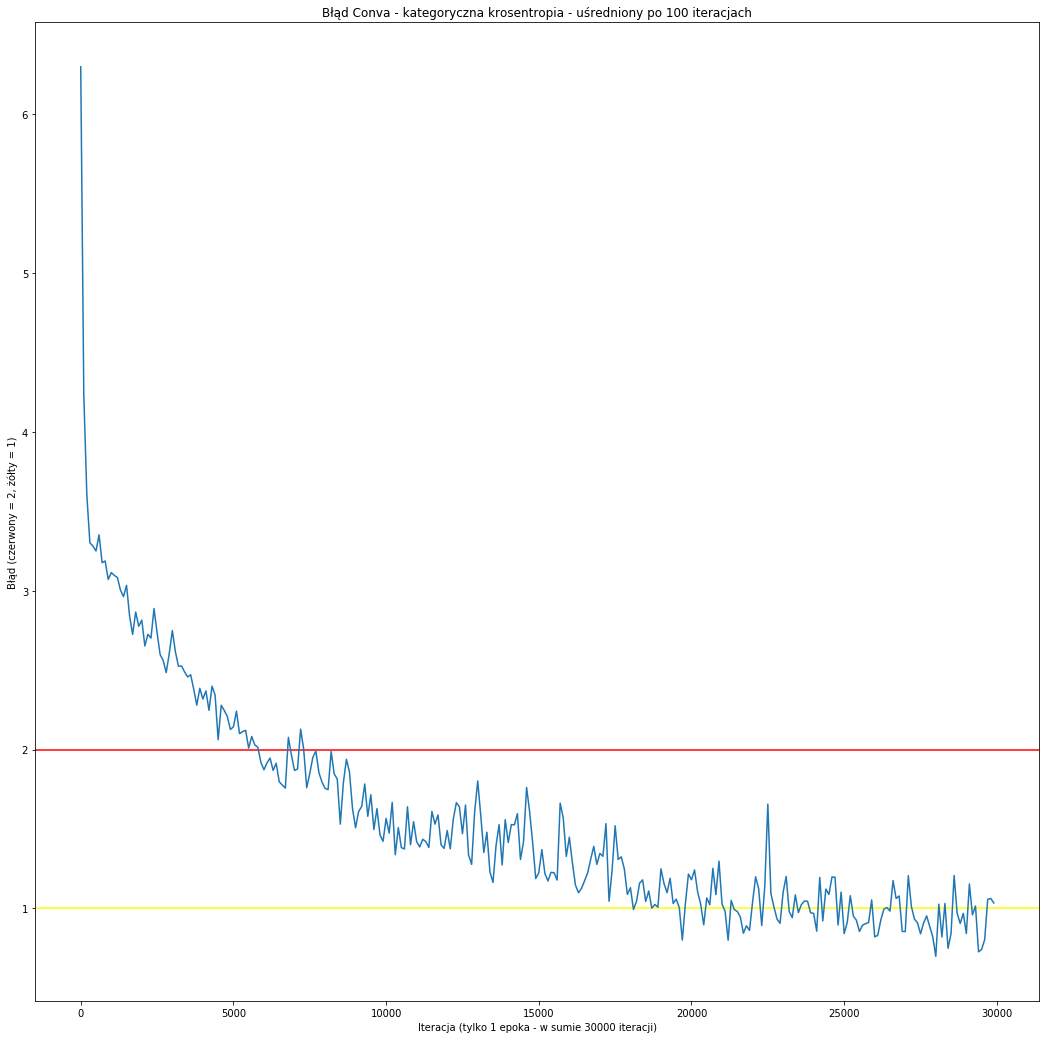

In [92]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=100
dt2=dt//kgbo

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(0, loopz+1, kgbo*50))
ax.set_xticks(range(0, loopz//kgbo+1, 50))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.plot(dkkk)
plt.show()

In [69]:
num=3000
won=0

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1    
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 3000 testach: 0.8493333333333334


In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]
